<a href="https://colab.research.google.com/github/HeshanNavindu-7/AgriConnect_mobile_app/blob/main/oilspill_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install opendatasets

In [15]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [16]:
od.download("https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/saanvitayal07/oil-spill-and-no-oil-spill


100%|██████████| 26.5M/26.5M [00:00<00:00, 121MB/s] 


# **visualizations**

In [17]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




test
train


Train Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


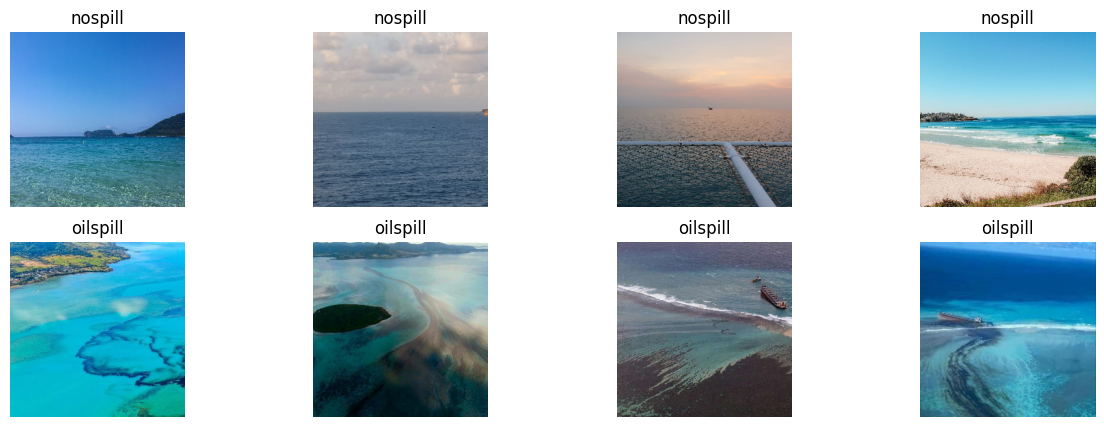

Test Data
Displaying 4 samples from 'nospill' class:
Displaying 4 samples from 'oilspill' class:


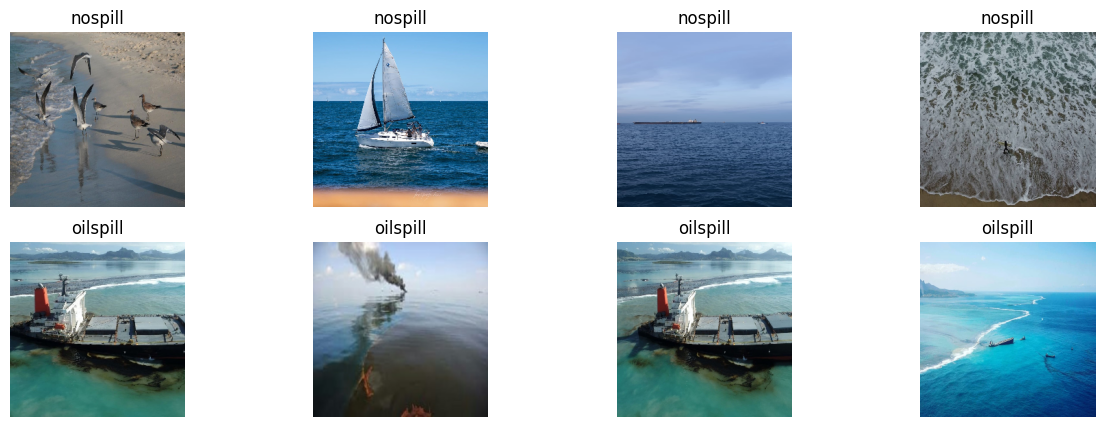

In [19]:
import cv2
import matplotlib.pyplot as plt
import os

# Define subdirectories for train and test data
train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'

# Define image size and batch size
target_size = (256, 256)
batch_size = 32

# Define classes
classes = ['nospill', 'oilspill']

# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        print(f"Displaying {num_samples} samples from '{class_name}' class:")

        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize image
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)


In [20]:
!pip install tensorflow-addons


In [21]:
!pip install tensorflow tensorflow-addons


In [22]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/train'
test_dir = '/content/oil-spill-and-no-oil-spill/oilspill_dataset_fix/test'
classes = ['nospill', 'oilspill']


In [23]:
def make_generator_model():
    inputs = layers.Input(shape=[256, 256, 3])
    x = layers.Conv2D(64, (7, 7), padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(3, (7, 7), padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def make_discriminator_model():
    inputs = layers.Input(shape=[256, 256, 3])
    x = layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

generator_g = make_generator_model()
generator_f = make_generator_model()
discriminator_x = make_discriminator_model()
discriminator_y = make_discriminator_model()


In [25]:
data_gen_args = dict(rescale=1./255,
                     rotation_range=40,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

train_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(256, 256),
                                                    batch_size=32,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(256, 256),
                                                  batch_size=32,
                                                  class_mode='binary')


Found 197 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [26]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
l2_loss = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return real_loss + generated_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    return l2_loss(real_image, cycled_image) * 10.0

def identity_loss(real_image, same_image):
    return l2_loss(real_image, same_image) * 10.0

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [27]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


In [28]:
import time
from IPython.display import clear_output

def train_cycle_gan(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_x, image_y in dataset:
            train_step(image_x, image_y)

        clear_output(wait=True)
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n')

AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1
    return image

def load_dataset(data_dir):
    data_paths = tf.data.Dataset.list_files(data_dir + '/*.jpg')
    dataset = data_paths.map(load_image, num_parallel_calls=AUTOTUNE)
    return dataset

train_dataset_x = load_dataset(train_dir + '/' + classes[0])
train_dataset_y = load_dataset(train_dir + '/' + classes[1])

train_dataset = tf.data.Dataset.zip((train_dataset_x, train_dataset_y)).batch(32).prefetch(AUTOTUNE)

train_cycle_gan(train_dataset, epochs=50)


Time taken for epoch 50 is 58.15 sec



In [29]:
combined_train_dir = '/content/oil-spill-and-no-oil-spill/combined_train'

combined_train_generator = train_datagen.flow_from_directory(combined_train_dir,
                                                             target_size=(256, 256),
                                                             batch_size=32,
                                                             class_mode='binary')


FileNotFoundError: [Errno 2] No such file or directory: '/content/oil-spill-and-no-oil-spill/combined_train'

In [1]:
import tensorflow_addons as tfa

# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
l2_loss = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return real_loss + generated_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    return l2_loss(real_image, cycled_image) * 10.0

def identity_loss(real_image, same_image):
    return l2_loss(real_image, same_image) * 10.0

# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training step
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

# Training loop
import time
from IPython.display import clear_output

def train_cycle_gan(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_x, image_y in dataset:
            train_step(image_x, image_y)

        clear_output(wait=True)
        print(f'Time taken for epoch {epoch + 1} is {time.time() - start:.2f} sec\n')

# Load data into TF Dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1
    return image

def load_dataset(data_dir):
    data_paths = tf.data.Dataset.list_files(data_dir + '/*.jpg')
    dataset = data_paths.map(load_image, num_parallel_calls=AUTOTUNE)
    return dataset

train_dataset_x = load_dataset(train_dir + '/' + classes[0])
train_dataset_y = load_dataset(train_dir + '/' + classes[1])

train_dataset = tf.data.Dataset.zip((train_dataset_x, train_dataset_y)).batch(32).prefetch(AUTOTUNE)

# Train CycleGAN
train_cycle_gan(train_dataset, epochs=50)


ModuleNotFoundError: No module named 'tensorflow_addons'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define preprocessing and data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    validation_split=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 197 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


## Build DL Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    Dropout(0.25),  # Dropout after the first convolutional layer
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.25),  # Dropout after the second convolutional layer
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.25),  # Dropout after the third convolutional layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout after the dense layer need to remove
    Dense(1, activation='sigmoid')
])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 dropout (Dropout)           (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                   

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 20.0 MB/s eta 0:00:00


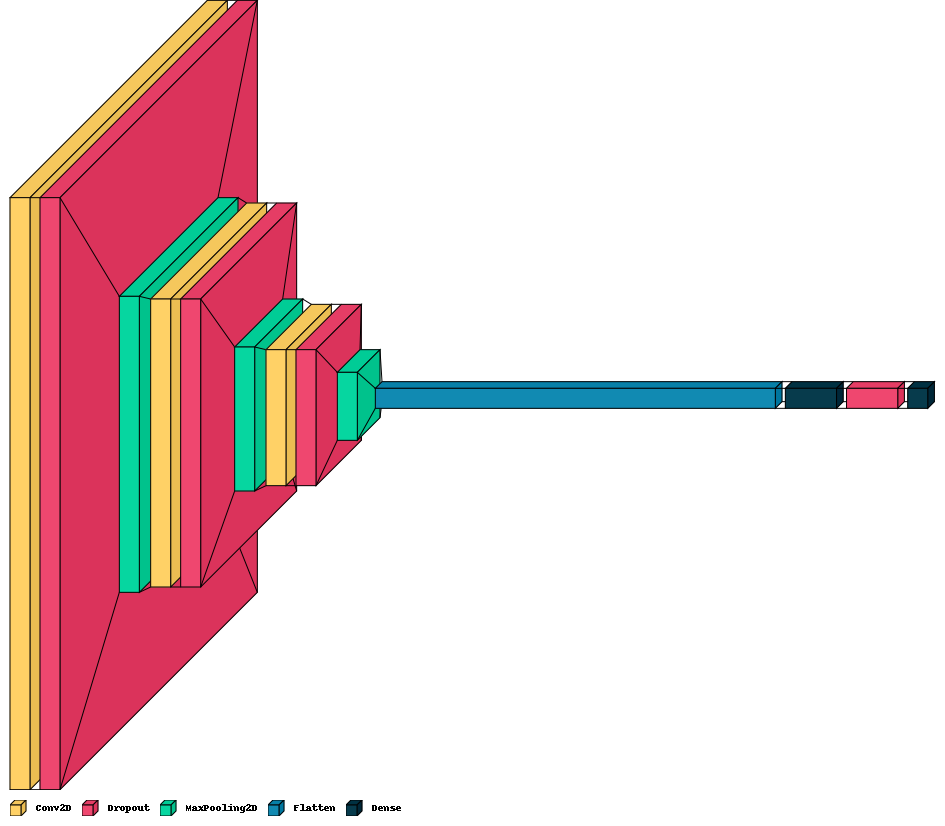

In [ ]:
import visualkeras
visualkeras.layered_view(model, legend=True)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/15
6/6 [==============================] - 19s 3s/step - loss: 4.1347 - accuracy: 0.5156 - val_loss: 0.7860 - val_accuracy: 0.4062
Epoch 2/15
6/6 [==============================] - 17s 2s/step - loss: 0.7302 - accuracy: 0.5697 - val_loss: 0.6765 - val_accuracy: 0.5312
Epoch 3/15
6/6 [==============================] - 16s 3s/step - loss: 0.6874 - accuracy: 0.5212 - val_loss: 0.6778 - val_accuracy: 0.5625
Epoch 4/15
6/6 [==============================] - 17s 3s/step - loss: 0.6816 - accuracy: 0.5156 - val_loss: 0.6606 - val_accuracy: 0.6250
Epoch 5/15
6/6 [==============================] - 17s 3s/step - loss: 0.6495 - accuracy: 0.6094 - val_loss: 0.6727 - val_accuracy: 0.5938
Epoch 6/15
6/6 [==============================] - 16s 2s/step - loss: 0.6890 - accuracy: 0.5636 - val_loss: 0.6924 - val_accuracy: 0.4688
Epoch 7/15
6/6 [==============================] - 17s 3s/step - loss: 0.6593 - accuracy: 0.6485 - val_loss: 0.6869 - val_accuracy: 0.5938
Epoch 8/15
6/6 [==================

In [ ]:
# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=batch_size,
    class_mode='binary'  # Since it's a binary classification task
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Found 49 images belonging to 2 classes.
2/2 [==============================] - 2s 457ms/step - loss: 0.6106 - accuracy: 0.6327
Test Loss: 0.6106379628181458
Test Accuracy: 0.6326530575752258


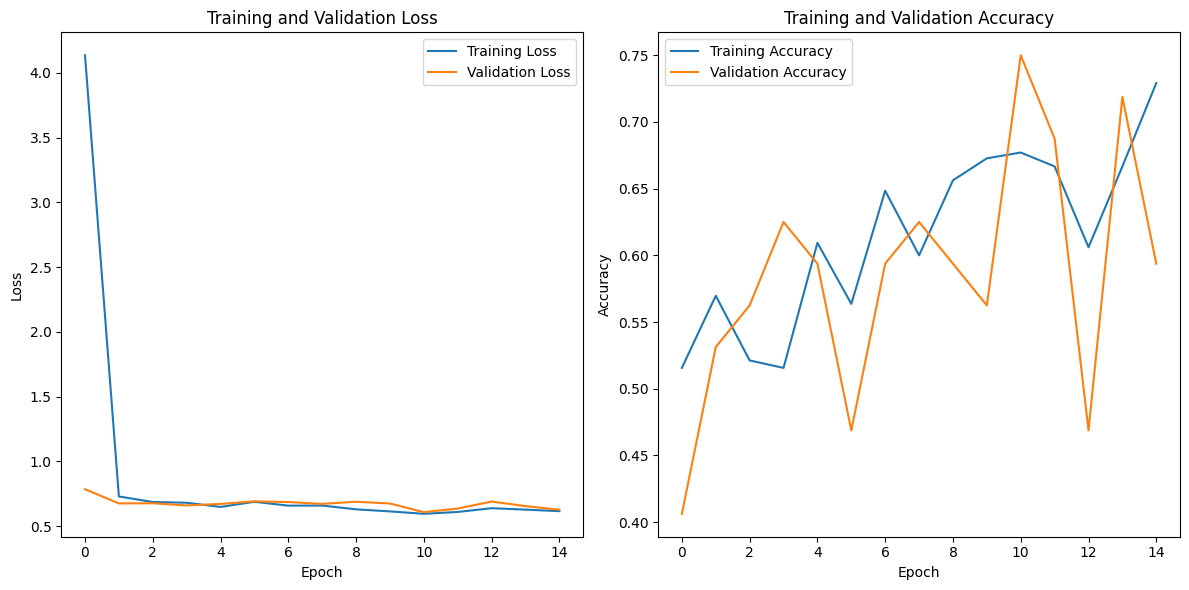

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()

# Plot training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:

print("Results")
result = model.evaluate_generator(test_generator, verbose=1)

print("%s%.2f" % ("Loss     : ", result[0]))
print("%s%.2f%s" % ("Accuracy : ", result[1] * 100, "%"))


Results


<ipython-input-14-11f1a34e3d1a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result = model.evaluate_generator(test_generator, verbose=1)


2/2 [==============================] - 1s 184ms/step - loss: 0.6106 - accuracy: 0.6327
Loss     : 0.61
Accuracy : 63.27%
